In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib
import math
from astropy import units as u
from astropy.modeling import models,fitting
from astropy.modeling import Model
from astropy.io import ascii
from astroquery.vizier import Vizier
import starkit
from starkit.fitkit.likelihoods import SpectralChi2Likelihood as Chi2Likelihood, SpectralL1Likelihood
from starkit.gridkit import load_grid
from starkit.fitkit.multinest.base import MultiNest, MultiNestResult
from starkit import assemble_model, operations
from starkit.fitkit import priors
from starkit.base.operations.spectrograph import (Interpolate, Normalize,
                                                  NormalizeParts,InstrumentConvolveGrating)
from starkit.base.operations.stellar import (RotationalBroadening, DopplerShift)
from starkit.fix_spectrum1d import SKSpectrum1D
from specutils import read_fits_file,plotlines
import numpy as np
import os,scipy
from specutils import Spectrum1D,rvmeasure
import datetime,glob
import model_tester_updated as mt
from matplotlib.backends.backend_pdf import PdfPages
import operator
import sys
from matplotlib.pyplot import cm
import multi_order_fitting_functions as mtf
from scipy.stats.stats import pearsonr, chisquare
from scipy.optimize import curve_fit
from scipy import ndimage as nd
import sl_response_plot_multiorder as slp
import scipy.stats


class Splitter3(Model):
    # split a single spectrum into 3
    inputs = ('w', 'f')
    outputs = ('w', 'f', 'w', 'f', 'w', 'f')

    def evaluate(self, w, f):
        return w, f, w, f, w, f


class Combiner3(Model):
    # combines the likelihood for four spectra
    inputs = ('l1', 'l2', 'l3')
    outputs = ('ltot',)

    def evaluate(self, l1, l2, l3):
        return l1 + l2 + l3
    
g = mtf.load_full_grid_bosz()

[starkit.gridkit.base][INFO   ]  Reading index (base.py:266)
[starkit.gridkit.base][INFO   ]  Discovered columns teff, logg, mh, alpha (base.py:269)
[starkit.gridkit.base][INFO   ]  Reading Fluxes (base.py:272)
[starkit.gridkit.base][INFO   ]  Fluxes shape (6790, 18233) (base.py:275)
[py.warnings         ][WARNING]  /u/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/astropy/units/format/generic.py:461: UnitsWarning: 'erg/s/angstrom' contains multiple slashes, which is discouraged by the FITS standard
  core.UnitsWarning)
 (generic.py:461)
[starkit.gridkit.base][INFO   ]  Initializing spec grid (base.py:309)
[starkit.gridkit.base][WARNING]  **** NO WAVELENGTH TYPE SET DEFAULTING TO GRID (vacuum) ****

 (base.py:75)


In [31]:
fitpath = '/u/rbentley/metallicity/spectra_fits/masked_fit_results/orders34-35-36/BOSZ_fits/unmasked/NGC6819_J19411+4010517_order34-36_bosz_fit_const_dl.h5'

starname = 'NGC6819_J19411+4010517'

In [33]:


cal_star_info_all = list(scipy.genfromtxt('/u/rbentley/metallicity/cal_star_info.dat', delimiter='\t', skip_header=1, dtype=None))
cal_star_info_all.sort(key=lambda x: x[1])
cal_star_names = [x[0] for x in cal_star_info_all[0:-1]]

[py.warnings         ][WARNING]  /Network/Servers/galaxy1.astro.ucla.edu/volume1/GhezGroup/home-directories/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  This is separate from the ipykernel package so we can avoid doing imports until
 (npyio.py:2068)


In [34]:
bosz_result = MultiNestResult.from_hdf5(
            '/u/rbentley/metallicity/spectra_fits/masked_fit_results/orders34-35-36/BOSZ_fits/unmasked/' + starname + '_order34-36_bosz_adderr.h5')

result = MultiNestResult.from_hdf5(fitpath)

In [35]:
snr=30.

file1 = glob.glob('/u/ghezgroup/data/metallicity/nirspec/spectra/' + starname + '_order34*.dat')
file2 = glob.glob('/u/ghezgroup/data/metallicity/nirspec/spectra/' + starname + '_order35*.dat')
file3 = glob.glob('/u/ghezgroup/data/metallicity/nirspec/spectra/' + starname + '_order36*.dat')

starspectrum34 = read_fits_file.read_nirspec_dat(file1, desired_wavelength_units='micron')
starspectrum35 = read_fits_file.read_nirspec_dat(file2, desired_wavelength_units='micron')
starspectrum36 = read_fits_file.read_nirspec_dat(file3, desired_wavelength_units='micron')

waverange34 = [np.amin(starspectrum34.wavelength.value[:970]), np.amax(starspectrum34.wavelength.value[:970])]
waverange35 = [np.amin(starspectrum35.wavelength.value[:970]), np.amax(starspectrum35.wavelength.value[:970])]
waverange36 = [np.amin(starspectrum36.wavelength.value[:970]), np.amax(starspectrum36.wavelength.value[:970])]

starspectrum34 = read_fits_file.read_nirspec_dat(file1, desired_wavelength_units='Angstrom',
                                                             wave_range=waverange34)
starspectrum35 = read_fits_file.read_nirspec_dat(file2, desired_wavelength_units='Angstrom',
                                                             wave_range=waverange35)
starspectrum36 = read_fits_file.read_nirspec_dat(file3, desired_wavelength_units='Angstrom',
                                                             wave_range=waverange36)

starspectrum34.uncertainty = (np.zeros(len(starspectrum34.flux.value)) + 1.0 / np.float(
                snr)) * starspectrum34.flux.unit
starspectrum35.uncertainty = (np.zeros(len(starspectrum35.flux.value)) + 1.0 / np.float(
                snr)) * starspectrum35.flux.unit
starspectrum36.uncertainty = (np.zeros(len(starspectrum36.flux.value)) + 1.0 / np.float(
                snr)) * starspectrum36.flux.unit

('clipping', [2.2403469, 2.2703373])
('clipping', [2.1811268, 2.2103229])
('clipping', [2.1168036, 2.1450112])


In [36]:
            #model = make_model_three_order(starspectrum34,starspectrum35,starspectrum36, g)
            interp1 = Interpolate(starspectrum34)
            #convolve1 = InstrumentConvolveGrating.from_grid(g, R=result.median['R_6'])#R=24000
            convolve1 = starkit.base.operations.spectrograph.InstrumentDeltaLambdaConstant.from_grid(g, delta_lambda=0.961)
            rot1 = RotationalBroadening.from_grid(g, vrot=np.array([10.0]))
            norm1 = Normalize(starspectrum34, 2)

            interp2 = Interpolate(starspectrum35)
            #convolve2 = InstrumentConvolveGrating.from_grid(g, R=result.median['R_7'])
            convolve2 = starkit.base.operations.spectrograph.InstrumentDeltaLambdaConstant.from_grid(g, delta_lambda=0.961)
            norm2 = Normalize(starspectrum35, 2)

            interp3 = Interpolate(starspectrum36)
            #convolve3 = InstrumentConvolveGrating.from_grid(g, R=result.median['R_8'])
            convolve3 = starkit.base.operations.spectrograph.InstrumentDeltaLambdaConstant.from_grid(g, delta_lambda=0.961)
            norm3 = Normalize(starspectrum36, 2)

            model = g | rot1 | Splitter3() | DopplerShift(vrad=0) & DopplerShift(vrad=0) & DopplerShift(vrad=0) | \
                    convolve1 & convolve2 & convolve3 | interp1 & interp2 & interp3 | \
                    norm1 & norm2 & norm3

In [37]:
        for a in result.median.keys():
            setattr(model, a, result.median[a])

In [38]:
bmodel = slp.make_model_three_order(starspectrum34, starspectrum35, starspectrum36, g)

for a in bosz_result.median.keys():
            setattr(bmodel, a, bosz_result.median[a])

In [39]:
print bmodel
print model

Model: CompoundModel83
Inputs: ()
Outputs: (u'wavelength0', u'flux0', u'wavelength1', u'flux1', 'wavelength', 'flux')
Model set size: 1
Expression: [0] | [1] | [2] | [3] & [4] & [5] | [6] & [7] & [8] | [9] & [10] & [11] | [12] & [13] & [14]
Components: 
    [0]: <SpectralGrid(teff=3500., logg=0., mh=0., alpha=0.)>

    [1]: <RotationalBroadening(vrot=[10.], limb_darkening=0.6)>

    [2]: <Splitter3()>

    [3]: <DopplerShift(vrad=0.)>

    [4]: <DopplerShift(vrad=0.)>

    [5]: <DopplerShift(vrad=0.)>

    [6]: <InstrumentRConstant(R=24000.)>

    [7]: <InstrumentRConstant(R=24000.)>

    [8]: <InstrumentRConstant(R=24000.)>

    [9]: <Interpolate()>

    [10]: <Interpolate()>

    [11]: <Interpolate()>

    [12]: <Normalize()>

    [13]: <Normalize()>

    [14]: <Normalize()>
Parameters:
          teff_0             logg_0              mh_0        ...   R_7     R_8  
    ------------------ ----------------- ------------------- ... ------- -------
    3886.2056949118833 1.2869082473307

In [40]:
result.median

teff_0            3881.656541
logg_0               1.214049
mh_0                -0.205832
alpha_0             -0.090108
vrot_1               1.257423
vrad_3            -410.720980
vrad_4             188.177845
vrad_5            -416.134086
delta_lambda_6       0.961000
delta_lambda_7       0.961000
delta_lambda_8       0.961000
add_err_15           0.001289
add_err_16           0.001302
add_err_17           0.000894
dtype: float64

In [41]:
bw1, bf1, bw2, bf2, bw3, bf3 = bmodel()
w1, f1, w2, f2, w3, f3 = bmodel()

In [42]:
        res1 = starspectrum34.flux.value - f1
        res2 = starspectrum35.flux.value - f2
        res3 = starspectrum36.flux.value - f3
        
        bosz_res1 = starspectrum34.flux.value - bf1
        bosz_res2 = starspectrum35.flux.value - bf2
        bosz_res3 = starspectrum36.flux.value - bf3

(-0.2, 1.3)

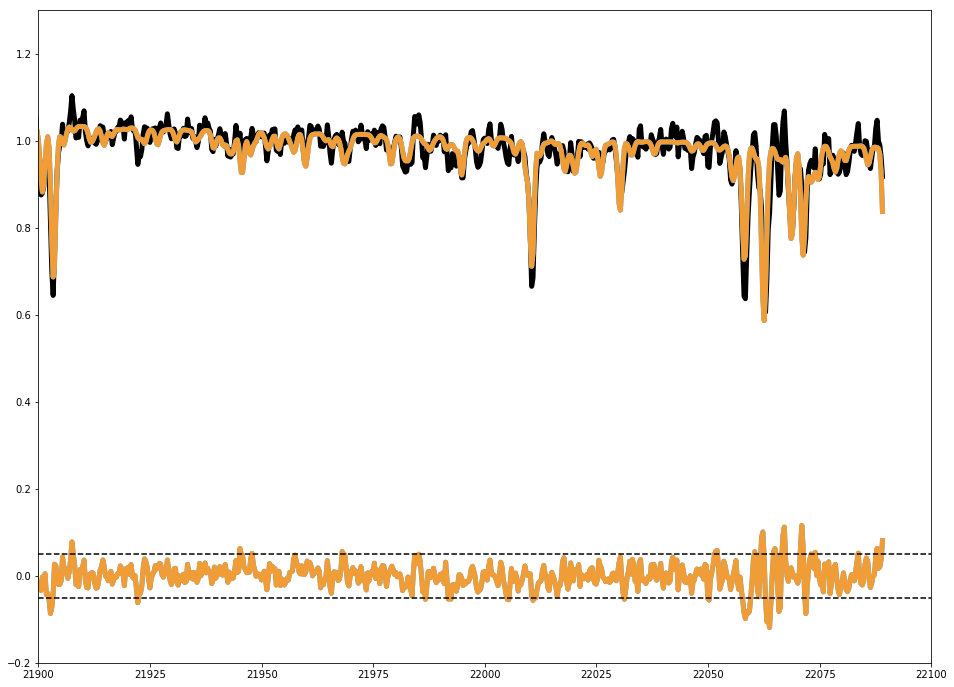

In [43]:
plt.figure(figsize=(16, 12))
plt.plot(starspectrum34.wavelength.value / (bosz_result.median['vrad_3'] / 3e5 + 1.0), starspectrum34.flux.value,
                 color='#000000', label='Data',linewidth=5.0)
plt.plot(starspectrum35.wavelength.value / (bosz_result.median['vrad_4'] / 3e5 + 1.0), starspectrum35.flux.value,
                 color='#000000',linewidth=5.0)
plt.plot(starspectrum36.wavelength.value / (bosz_result.median['vrad_5'] / 3e5 + 1.0), starspectrum36.flux.value,
                 color='#000000',linewidth=5.0)

plt.plot(bw2 / (bosz_result.median['vrad_4'] / 3e5 + 1.0), bf2, color='#33AFFF', label='Reference BOSZ Model/Residuals',linewidth=5.0)

plt.plot(bw2 / (bosz_result.median['vrad_4'] / 3e5 + 1.0), bosz_res2, color='#33AFFF',linewidth=5.0)

plt.plot(w2 / (result.median['vrad_4'] / 3e5 + 1.0), f2, color='#f09c37', label='Model/Residuals',linewidth=5.0)

plt.plot(w2 / (result.median['vrad_4'] / 3e5 + 1.0), res2, color='#f09c37',linewidth=5.0)



plt.axhline(y=0.05, color='k', linestyle='--', label='$\pm$ 5%')
plt.axhline(y=-0.05, color='k', linestyle='--')

plt.xlim(21900,22100)
plt.ylim(-0.2,1.3)